In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [62]:
df_raw = pd.read_csv("/content/insurance.csv")
df_raw.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [63]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [64]:
# Check missing values
df_raw.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


# Step 1: Handling Missing Values

In [65]:
df = df_raw.copy()

df.loc[df.sample(frac=0.05, random_state=42).index, 'bmi'] = np.nan
df.loc[df.sample(frac=0.03, random_state=1).index, 'region'] = np.nan


In [66]:
df.isnull().sum()


,0
age,0
sex,0
bmi,67
children,0
smoker,0
region,40
charges,0


In [67]:
# Numerical → Median imputation
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# Categorical → Mode imputation
df['region'] = df['region'].fillna(df['region'].mode()[0])

print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


Explanation

Median (BMI): Robust to outliers, suitable for skewed numerical data.

Mode (Region): Most frequent category preserves categorical distribution.


# Step 2: Noise Detection and Handling

In [68]:
#Add Artificial Noise
df['charges_noisy'] = df['charges'] + np.random.normal(0, 1000, size=len(df))


In [69]:
#Noise Handling (Moving Average)
df['charges_smoothed'] = df['charges_noisy'].rolling(window=10).mean()



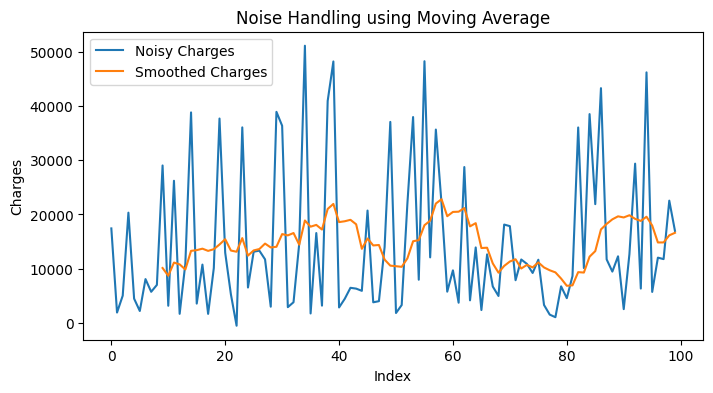

In [70]:
plt.figure(figsize=(8,4))
plt.plot(df['charges_noisy'][:100], label="Noisy Charges")
plt.plot(df['charges_smoothed'][:100], label="Smoothed Charges")
plt.xlabel("Index")
plt.ylabel("Charges")
plt.title("Noise Handling using Moving Average")
plt.legend()
plt.show()


Explanation:
Moving average smoothing reduces random fluctuations and highlights the underlying trend.

# Step 3: Outlier Detection and Handling

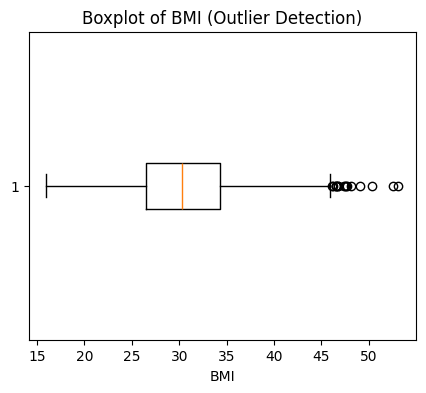

In [71]:
plt.figure(figsize=(5,4))
plt.boxplot(df['bmi'], vert=False)
plt.title("Boxplot of BMI (Outlier Detection)")
plt.xlabel("BMI")
plt.show()


In [72]:
#Detect Outliers (Z-Score Method)
z_scores = np.abs(stats.zscore(df['bmi']))
print("Number of outliers detected:", (z_scores > 3).sum())

Number of outliers detected: 4


In [73]:
#Remove Outliers
df_no_outliers = df[z_scores < 3]
print("Shape after outlier removal:", df_no_outliers.shape)

Shape after outlier removal: (1334, 9)


Justification:
Extreme BMI values can distort analysis, so removing them improves data quality.

# Step 4: Data Transformation

In [74]:
#One-Hot Encoding
df_encoded = pd.get_dummies(df_no_outliers, columns=['region'], drop_first=True)


print("Encoded dataset:")
display(df_encoded.head())

Encoded dataset:


,age,sex,bmi,children,smoker,charges,charges_noisy,charges_smoothed,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,16884.92400,17425.433889,NaN,False,False,True
1,18,male,33.770,1,no,1725.55230,1885.374603,NaN,False,True,False
2,28,male,33.000,3,no,4449.46200,5003.414115,NaN,False,True,False
3,33,male,22.705,0,no,21984.47061,20334.287337,NaN,False,True,False
4,32,male,28.880,0,no,3866.85520,4458.433279,NaN,True,False,False


In [80]:
#Feature Engineering (Binning BMI)
df_encoded['bmi_category'] = pd.cut(
    df_encoded['bmi'],
    bins=[0, 18.5, 25, 30, 100],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese']
)

print("BMI categories distribution:")
print(df_encoded['bmi_category'].value_counts())


BMI categories distribution:
bmi_category
Obese          730
Overweight     365
Normal         219
Underweight     20
Name: count, dtype: int64


Explanation:
Encoding converts categorical data into numerical form, while binning improves interpretability.

# Step 5: Feature Scaling

In [76]:
#Select Numerical Features
features = ['age', 'bmi', 'charges']


In [77]:
#Standardization (Z-Score)
scaler_std = StandardScaler()
df_encoded[['age_std', 'bmi_std', 'charges_std']] = scaler_std.fit_transform(
    df_encoded[features]
)

print("Standardized features:")
display(df_encoded[['age_std','bmi_std','charges_std']].head())

Standardized features:


,age_std,bmi_std,charges_std
0,-1.442249,-0.452311,0.299484
1,-1.513528,0.550513,-0.954898
2,-0.800739,0.418967,-0.729505
3,-0.444344,-1.339820,0.721452
4,-0.515623,-0.284889,-0.777713


In [78]:
#Normalization (Min-Max)
scaler_mm = MinMaxScaler()
df_encoded[['age_mm', 'bmi_mm', 'charges_mm']] = scaler_mm.fit_transform(
    df_encoded[features]
)

print("Normalized features:")
display(df_encoded[['age_mm','bmi_mm','charges_mm']].head())


Normalized features:


,age_mm,bmi_mm,charges_mm
0,0.021739,0.371847,0.251611
1,0.000000,0.554656,0.009636
2,0.217391,0.530676,0.053115
3,0.326087,0.210059,0.333010
4,0.304348,0.402367,0.043816


Explanation:
Z-score is preferred when data is normally distributed, while Min-Max scaling is useful when values must lie within a fixed range.

# Final Processed Data

In [79]:
print("Final processed dataset:")
display(df_encoded.head())


Final processed dataset:


,age,sex,bmi,children,smoker,charges,charges_noisy,charges_smoothed,region_northwest,region_southeast,region_southwest,bmi_category,age_std,bmi_std,charges_std,age_mm,bmi_mm,charges_mm
0,19,female,27.900,0,yes,16884.92400,17425.433889,NaN,False,False,True,Overweight,-1.442249,-0.452311,0.299484,0.021739,0.371847,0.251611
1,18,male,33.770,1,no,1725.55230,1885.374603,NaN,False,True,False,Obese,-1.513528,0.550513,-0.954898,0.000000,0.554656,0.009636
2,28,male,33.000,3,no,4449.46200,5003.414115,NaN,False,True,False,Obese,-0.800739,0.418967,-0.729505,0.217391,0.530676,0.053115
3,33,male,22.705,0,no,21984.47061,20334.287337,NaN,False,True,False,Normal,-0.444344,-1.339820,0.721452,0.326087,0.210059,0.333010
4,32,male,28.880,0,no,3866.85520,4458.433279,NaN,True,False,False,Overweight,-0.515623,-0.284889,-0.777713,0.304348,0.402367,0.043816
